In [181]:
import sys
sys.path.append('/Users/marijnvandermeer/opt/anaconda3/envs/env_pytorch/lib/python3.6/site-packages')


from torch import empty
from linear import Linear
from relu import ReLU
from leakyrelu import LeakyReLU
from generate_dataset import generate_set

import math
import torch
from torch.utils.data import DataLoader
torch.set_grad_enabled(True)

In [182]:
import autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, pairs, target):
        'Initialization'
        # target = (0,1)
        self.target = target
        # image pairs (2,14,14)
        self.pairs = pairs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.pairs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # image pairs
        X = self.pairs[index]
        # target:
        y = self.target[index]
        return X, y

In [184]:
# ------------------------------------------------------------------
# Control the randomness
# ------------------------------------------------------------------
torch.manual_seed(0)

N = 1000
center = (0.5, 0.5)
r = 1 / (math.sqrt(2 * math.pi))
training_data, training_labels = generate_set(N, center, r)
test_data, test_labels = generate_set(N, center, r)

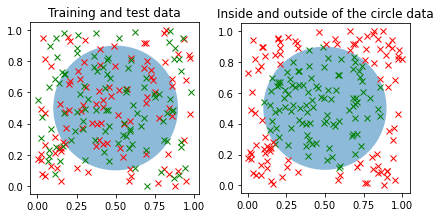

In [185]:
# test my function :) 
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.tight_layout()

circle1 = plt.Circle(center, r, alpha = 0.5)
axs[0].set_title("Training and test data")
axs[0].set_aspect('equal')
axs[0].add_patch(circle1)
for point in training_data[:100]:
    axs[0].plot(point[0], point[1], 'x',color = 'r', label = 'training')
for point in test_data[:100]:
    axs[0].plot(point[0], point[1], 'x',color = 'g', label = 'test')

circle2 = plt.Circle(center, r, alpha = 0.5)
axs[1].set_title("Inside and outside of the circle data")
axs[1].set_aspect('equal')
axs[1].add_patch(circle2)
for point in training_data[training_labels.type(torch.BoolTensor)][:100]:
    axs[1].plot(point[0], point[1], 'x',color = 'g', label = 'training')
for point in training_data[~training_labels.type(torch.BoolTensor)][:100]:
    axs[1].plot(point[0], point[1], 'x',color = 'r', label = 'training')
    
plt.show()

In [231]:
training_set = Dataset(training_data, training_labels.type(torch.LongTensor))
test_set = Dataset(test_data, test_labels.type(torch.LongTensor))

In [274]:
# Basic model with two layers and a two digit output:
import torch.nn as nn
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 2
        hidden_sizes = [25, 25, 25]
        # two digit output, probability of being 1 or 0:
        output_size = 2
        # flatten images to 1D input:
        self.flatten = nn.Flatten()
        # then two hidden layers:
        self.model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                   nn.ReLU(),
                                   nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                   nn.Tanh(),
                                   nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                                   nn.Tanh(),
                                   nn.Linear(hidden_sizes[2], output_size))
        # no need to add softmax at the end because already in CE loss.
    def forward(self, x):
        # flatten 2D->1D
        x = self.flatten(x)
        # predict probabilities:
        logits = self.model(x)
        return logits

In [275]:
# Data loader for model, change num_workers when on GPU:
params = {'batch_size':4, 'shuffle': True, 'num_workers': 0}
training_generator = torch.utils.data.DataLoader(training_set, **params)
test_generator = torch.utils.data.DataLoader(test_set, **params)

In [276]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Model_1().to(device)
print(model)

Model_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=2, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): Tanh()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): Tanh()
    (6): Linear(in_features=25, out_features=2, bias=True)
  )
)


In [277]:
softmax = torch.nn.Softmax(dim=1)

def train_loop(dataloader, model, loss_fn, optimizer, print_values = False):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss:
        logits = model(X)
        
        # Softmax to get probabilities:
        prob = softmax(logits)
        
        # calculate number of correct predictions:
        correct += (prob.argmax(1) == y).type(torch.float).sum().item()
                
        # [0-1] pred loss:
        loss = loss_fn(logits, y)
        #loss.requires_grad = True

        # Backpropagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # return average training loss:
    correct /= size
    train_loss /= size
    return 100 * correct, train_loss

In [278]:
def test_loop(dataloader, model, loss_fn, e, print_values = True):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    softmax = torch.nn.Softmax(dim=1)
    roc = 0
    with torch.no_grad():
        for X, y in dataloader:
            logits = model(X)
            
            # [0-1] pred loss:
            loss = loss_fn(logits, y)
            test_loss += loss.item()
            
            # Softmax to get probabilities:
            prob = softmax(logits)

            # calculate number of correct predictions:
            correct += (prob.argmax(1) == y).type(torch.float).sum().item()    
            
    # return average test loss and accuracy:
    test_loss /= size
    correct /= size

    epsilon = 1e-7
    if e % 10 == 0:
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100 * correct, test_loss

In [279]:
def train_eval(model,
               optimizer,
               loss_fn,
               training_generator, test_generator,
               epochs=25,
               save=False,
               print_loss=False,
               print_epoch=False):

    train_perf, test_perf = [], []

    for t in range(epochs):
        if print_epoch:
            if t % 10 == 0:
                print(f"Epoch {t+1}\n-------------------------------")
        train_perf.append(
            train_loop(training_generator,
                       model,
                       loss_fn,
                       optimizer))
        test_perf.append(
            test_loop(test_generator,
                      model,
                      loss_fn, e = t))
    return train_perf, test_perf

In [280]:
def plot_performance(train_perf, test_perf):
    def sub_plot(axs_id, train_data, test_data, train_label, test_label,
                 x_label, title):
        axs[axs_id].plot(train_data, label=train_label)
        axs[axs_id].plot(test_data, label=test_label)
        axs[axs_id].set_xlabel(x_label)
        axs[axs_id].set_title(title)
        axs[axs_id].legend()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    train_accs = list(zip(*train_perf))[0]
    test_accs = list(zip(*test_perf))[0]
    
    # Accuracy 0-1 and F1 score:
    sub_plot(0, train_accs, test_accs, 'train accuracy', 'test accuracy',
             'Num epochs', 'Accuracy')
    axs[0].legend()
    
    # Losses:
    train_losses = list(zip(*train_perf))[1]
    test_losses = list(zip(*test_perf))[1]
    sub_plot(1, train_losses, test_losses, 'train loss', 'test loss',
             'Num epochs', 'Loss')

In [281]:
learning_rate = 1e-3
batch_size = 4
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#loss_fn = nn.MSELoss()
loss_fn = nn.CrossEntropyLoss()

Epoch 1
-------------------------------
Validation Error: 
 Accuracy: 68.0%, Avg loss: 0.167925 

Epoch 11
-------------------------------
Validation Error: 
 Accuracy: 98.0%, Avg loss: 0.014893 

Epoch 21
-------------------------------
Validation Error: 
 Accuracy: 98.3%, Avg loss: 0.011419 

Epoch 31
-------------------------------
Validation Error: 
 Accuracy: 98.9%, Avg loss: 0.008680 

Epoch 41
-------------------------------
Validation Error: 
 Accuracy: 97.7%, Avg loss: 0.015773 

Epoch 51
-------------------------------
Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.020973 

Epoch 61
-------------------------------
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.007962 

Epoch 71
-------------------------------
Validation Error: 
 Accuracy: 97.9%, Avg loss: 0.011044 

Epoch 81
-------------------------------
Validation Error: 
 Accuracy: 98.0%, Avg loss: 0.008857 

Epoch 91
-------------------------------
Validation Error: 
 Accuracy: 96.9%, Avg loss: 0.016248 



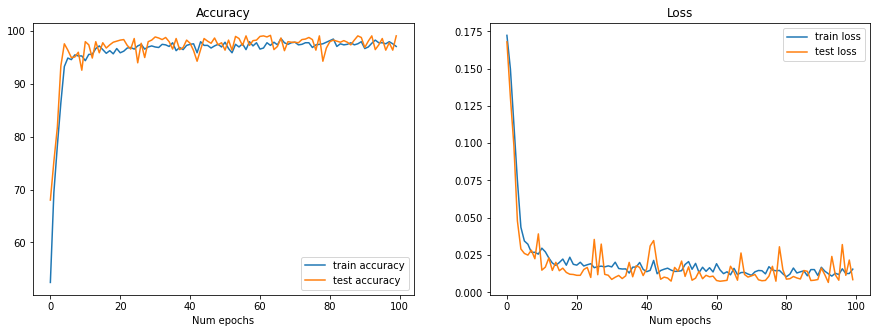

In [282]:
train_perf, test_perf = train_eval(model,optimizer,
                   loss_fn,training_generator, test_generator,
                   epochs,
                   print_loss=True,
                   print_epoch=True)

plot_performance(train_perf, test_perf)